In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

In [3]:
life_df = pd.read_csv('/content/Life Expectancy Data.csv')

In [4]:
life_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

In [5]:
life_df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [9]:
correlation = life_df.corr()
cor_target = abs(correlation['Life expectancy '])

corr_features = cor_target[cor_target > 0.5]
corr_features.sort_values(ascending= False)

<ipython-input-9-9ec80c5347d5>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = life_df.corr()


Life expectancy                    1.000000
Schooling                          0.751975
Income composition of resources    0.724776
Adult Mortality                    0.696359
 BMI                               0.567694
 HIV/AIDS                          0.556556
Name: Life expectancy , dtype: float64

Check for Multicollinearity

In [10]:
highcorrelation = life_df[list(corr_features.index)].corr()
consider = highcorrelation[highcorrelation > 0.55]
consider

,Life expectancy,Adult Mortality,BMI,HIV/AIDS,Income composition of resources,Schooling
Life expectancy,1.000000,NaN,0.567694,NaN,0.724776,0.751975
Adult Mortality,NaN,1.0,NaN,NaN,NaN,NaN
BMI,0.567694,NaN,1.000000,NaN,NaN,NaN
HIV/AIDS,NaN,NaN,NaN,1.0,NaN,NaN
Income composition of resources,0.724776,NaN,NaN,NaN,1.000000,0.800092
Schooling,0.751975,NaN,NaN,NaN,0.800092,1.000000


Keep all variables create new interaction variable of schooling and income composition of resources

Analyze Categorical Vars

In [11]:
categorical = []

for column in life_df.columns:
  if len(life_df[column].unique()) < 20:
    categorical.append(column)

In [21]:
def barplots(categorical, target):
  i = 0
  title = "Average of: " + str(target)

  while i < len(categorical):
    plt.figure(figsize = (18, 6))

    plt.subplot(1, 3, 1)
    sns.barplot(x = life_df[categorical[i]], y = life_df[target])
    plt.setp(plt.gca().get_xticklabels(), rotation= 45, horizontalalignment= 'right')
    plt.title(title)

    if i+1 < len(categorical):
      plt.subplot(1, 3, 2)
      sns.barplot(x = life_df[categorical[i+1]], y = life_df[target])
      plt.setp(plt.gca().get_xticklabels(), rotation= 45, horizontalalignment= 'right')
      plt.title(title)

    if i+2 < len(categorical):
      plt.subplot(1, 3, 3)
      sns.barplot(x = life_df[categorical[i+2]], y = life_df[target])
      plt.setp(plt.gca().get_xticklabels(), rotation= 45, horizontalalignment= 'right')
      plt.title(title)

    plt.show()

    i += 3

def statdifference(catvariables, target):

  for categoricalvar in catvariables:
    values = life_df[categoricalvar].unique()

    print("*----------------------------------*")
    print("Comaprison of variables: {} and {}".format(target, categoricalvar))
    print("*----------------------------------*")

    for i in range(0, len(values)):
      for j in range(i+1, len(values)):
        print("t-test between groups {0} and {1}: ".format(values[i], values[j]))
        print(stats.ttest_ind(life_df.dropna()[life_df[categoricalvar]==values[i]][target], life_df.dropna()[life_df[categoricalvar]==values[j]][target]))

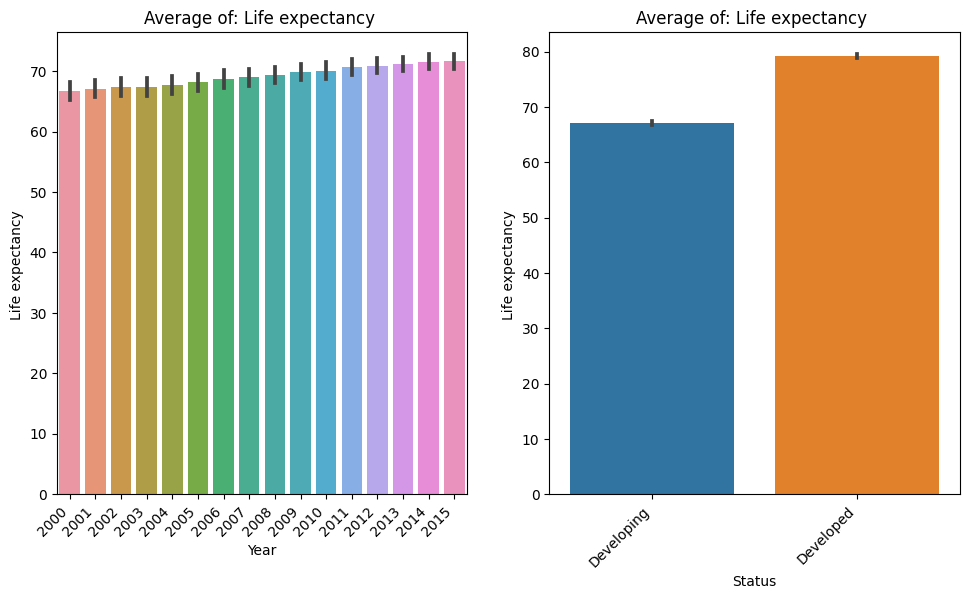

In [22]:
barplots(categorical, 'Life expectancy ')

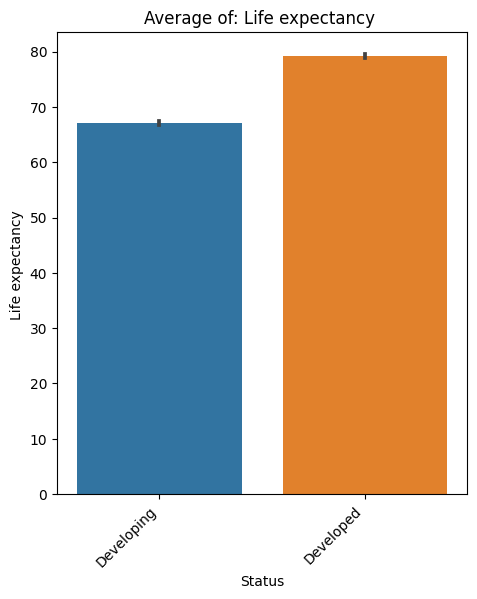

In [23]:
selectedvars = ['Status']
barplots(selectedvars, 'Life expectancy ')

In [24]:
statdifference(selectedvars, 'Life expectancy ')

*----------------------------------*
Comaprison of variables: Life expectancy  and Status
*----------------------------------*
t-test between groups Developing and Developed: 
TtestResult(statistic=-20.04208196882747, pvalue=3.9228534194275335e-80, df=1647.0)


<ipython-input-21-f5b78759b11d>:41: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(stats.ttest_ind(life_df.dropna()[life_df[categoricalvar]==values[i]][target], life_df.dropna()[life_df[categoricalvar]==values[j]][target]))


Get dummies

In [29]:
dummy_column_names = []

for varcat in selectedvars:
  dropFirst = False

  if len(life_df[varcat].unique()) == 2:
    dropFirst = True

  life_df = pd.concat([life_df, pd.get_dummies(life_df[varcat], prefix = varcat, drop_first=dropFirst)], axis= 1)
  dummy_column_names = dummy_column_names + list(pd.get_dummies(life_df[varcat], prefix= varcat, drop_first=dropFirst).columns)

In [30]:
life_df['Status'].unique()

array(['Developing', 'Developed'], dtype=object)

In [31]:
dummy_column_names

['Status_Developing']

Clean Selected Features

Nulls in light green


<Axes: >

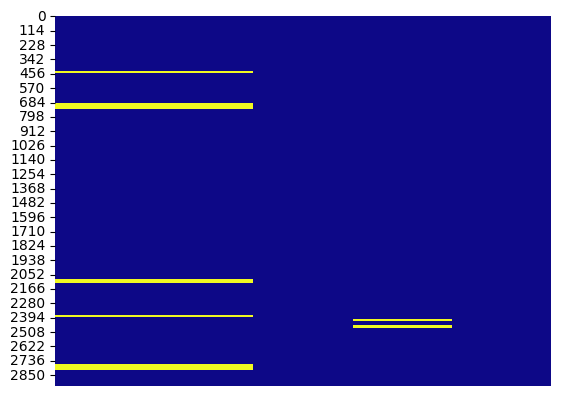

In [34]:
print('Nulls in light green')

sns.heatmap(life_df[['Schooling', 'Income composition of resources', 'Adult Mortality', ' BMI ', ' HIV/AIDS']].isnull(), xticklabels= False, cbar= False, cmap= 'plasma')

In [35]:
life_df.fillna(life_df.mean(numeric_only= True).round(2), inplace= True)
print(life_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2938 non-null   float64
 4   Adult Mortality                  2938 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2938 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2938 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2938 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

Nulls in light green


<Axes: >

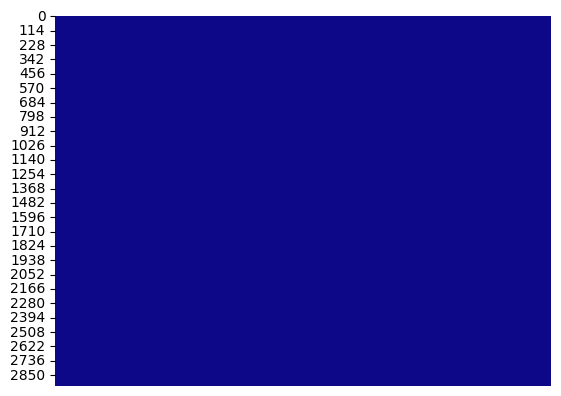

In [36]:
print('Nulls in light green')

sns.heatmap(life_df[['Schooling', 'Income composition of resources', 'Adult Mortality', ' BMI ', ' HIV/AIDS']].isnull(), xticklabels= False, cbar= False, cmap= 'plasma')

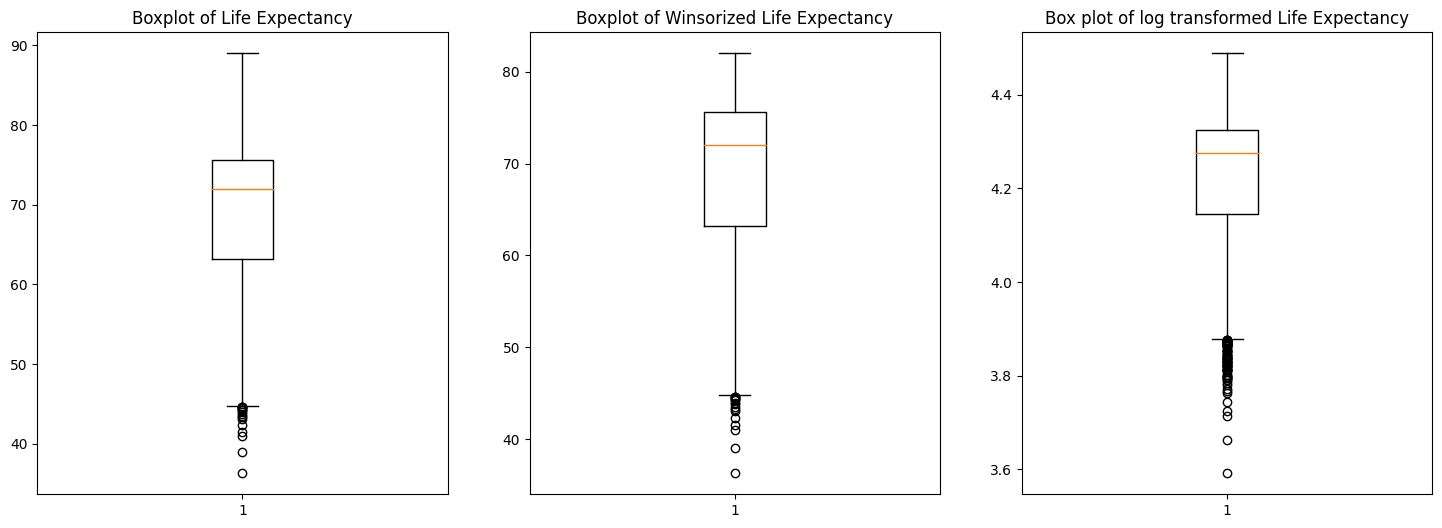

In [39]:
from scipy.stats.mstats import winsorize

winsorized_life = winsorize(life_df['Life expectancy '], (0, 0.05))

plt.figure(figsize= (18, 6))

plt.subplot(1, 3, 1)
plt.boxplot(life_df['Life expectancy '])
plt.title('Boxplot of Life Expectancy')

plt.subplot(1, 3, 2)
plt.boxplot(winsorized_life)
plt.title("Boxplot of Winsorized Life Expectancy")

plt.subplot(1,3,3)
plt.boxplot(np.log(life_df['Life expectancy ']))
plt.title("Box plot of log transformed Life Expectancy")

plt.show()

We are not going to transoform the Life Expectancy variable as it does not improve the model

In [55]:
# Creating interaction variable
life_df['Schooling_Resource'] = life_df['Schooling'] * life_df['Income composition of resources']

# Creating X features
X = life_df[['Schooling_Resource', 'Adult Mortality', ' BMI ', ' HIV/AIDS'] + dummy_column_names]

# Creating y target variable
y = life_df['Life expectancy ']

# Add constant

X = sm.add_constant(X)

OLS Model

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 42)

In [57]:
lrm = LinearRegression()
lrm.fit(X_train, y_train)

# We are making predictions here
y_preds_test = lrm.predict(X_test)
accuracy=cross_val_score(lrm, X_train, y_train, cv=5)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))
print("Accuracy: %0.3f (+/- %0.3f)" % (accuracy.mean(), accuracy.std() * 2))


R-squared of the model in the training set is: 0.779755669326387
-----Test set statistics-----
R-squared of the model in the test set is: 0.7679071536849893
Mean absolute error of the prediction is: 3.2096154026074895
Mean squared error of the prediction is: 20.107426408200894
Root mean squared error of the prediction is: 4.484130507489818
Mean absolute percentage error of the prediction is: 4.961238879081533
Accuracy: 0.775 (+/- 0.044)


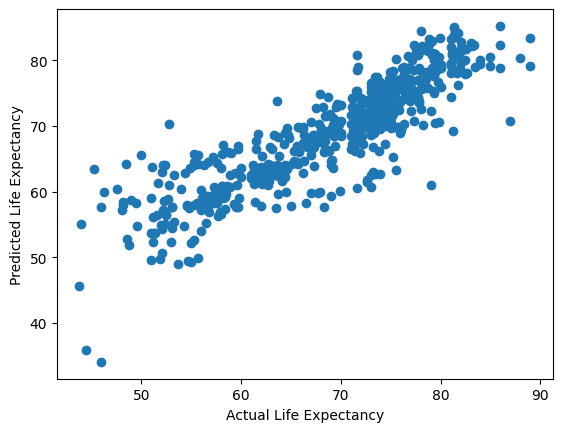

In [58]:
plt.scatter(y_test,y_preds_test)
plt.xlabel('Actual Life Expectancy')
plt.ylabel('Predicted Life Expectancy')
plt.show()

In [59]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors= 11)
knn.fit(X_train, y_train)

y_preds_test = knn.predict(X_test)
accuracy=cross_val_score(knn, X_train, y_train, cv=5)

print("R-squared of the model in the training set is: {}".format(knn.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(knn.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))
print("Accuracy: %0.3f (+/- %0.3f)" % (accuracy.mean(), accuracy.std() * 2))

R-squared of the model in the training set is: 0.9304025577825028
-----Test set statistics-----
R-squared of the model in the test set is: 0.9306406360542704
Mean absolute error of the prediction is: 1.758750773036487
Mean squared error of the prediction is: 6.008967223252935
Root mean squared error of the prediction is: 2.4513194861651417
Mean absolute percentage error of the prediction is: 2.6358484007226433
Accuracy: 0.905 (+/- 0.024)


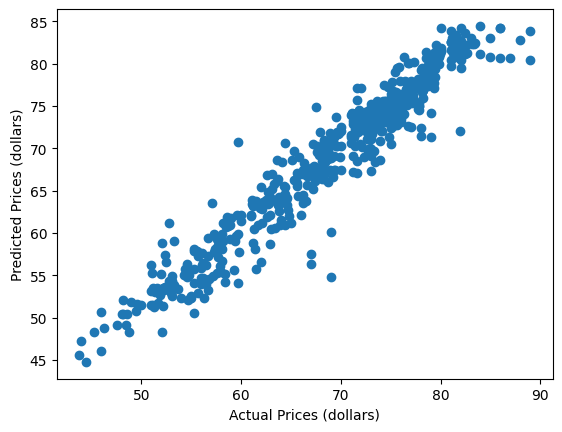

In [60]:
plt.scatter(y_test,y_preds_test)
plt.xlabel('Actual Prices (dollars)')
plt.ylabel('Predicted Prices (dollars)')
plt.show()

Choosing best K

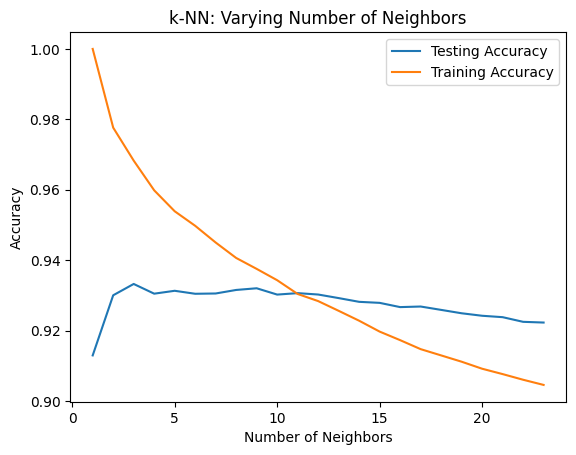

In [61]:
no_neighbors = np.arange(1, 24)

train_accuracy = np.empty(len(no_neighbors))
test_accuracy = np.empty(len(no_neighbors))

for i, k in enumerate(no_neighbors):
  knn = KNeighborsRegressor(n_neighbors= k)
  knn.fit(X_train, y_train)

  train_accuracy[i] = knn.score(X_train, y_train)

  test_accuracy[i] = knn.score(X_test, y_test)

# Visualize

plt.title('k-NN: Varying Number of Neighbors')
plt.plot(no_neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(no_neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

n-neighbor value of 11 seems to be the best for predicting new data